In [1]:
import matplotlib.pyplot as plt
import pickle 
from pathlib import Path as P
from matplotlib.patches import Rectangle as Rec
import numpy as np
from pcdet.utils import calibration_kitti
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from tqdm import tqdm
from vod.visualization.settings import label_color_palette_2d

In [2]:
frame_id = '004850'
# frame_id = '007008'
dpp_result = {}
for layer_id in range(0, 4):
    dpp_enable_xyz = np.load('/root/hantao/CenterPoint-KITTI/dpp_vis/layer_gate_vis/dpp_enable_points_list_%s_dpp_enable_layer_%s.npy' % (frame_id, layer_id))
    dpp_disable_xyz = np.load('/root/hantao/CenterPoint-KITTI/dpp_vis/layer_gate_vis/dpp_enable_points_list_%s_dpp_disable_layer_%s.npy' % (frame_id, layer_id))
    layer_xyz = np.load('/root/hantao/CenterPoint-KITTI/dpp_vis/layer_gate_vis/dpp_enable_points_list_%s_layer_xyz_layer_%s.npy' % (frame_id, layer_id))
    sample_gt = np.load('/root/hantao/CenterPoint-KITTI/dpp_vis/layer_gate_vis/dpp_enable_points_list_%s_gt_layer_%s.npy' % (frame_id, layer_id))
    dpp_result[layer_id] = {'dpp_enable_xyz': dpp_enable_xyz, 'dpp_disable_xyz': dpp_disable_xyz, 'layer_xyz': layer_xyz, 'sample_gt': sample_gt}

In [3]:
def points_in_bev_bounding_box(point_cloud, annons):
    count = 0

    loc = annons[:, 0:3]
    dim = annons[:, 3:6]
    rot = annons[:, 6:7]
    angle = rot

    for i in range(len(dim)):
        # Create rotation matrix
        R = np.array([[np.cos(angle[i]), -np.sin(angle[i]), 0],
                      [np.sin(angle[i]),  np.cos(angle[i]), 0],
                      [0, 0, 1]])


        # Shift the point cloud to align with the bounding box's center
        shifted_points = point_cloud - loc[i]

        # Rotate the points around the center of the bounding box
        rotated_points = np.matmul(shifted_points, R.T)

        # Check if the rotated points are within the bounding box dimensions
        mask = (np.abs(rotated_points[:, 0]) < dim[i][0] / 2) & (np.abs(rotated_points[:, 1]) < dim[i][1] / 2) & (np.abs(rotated_points[:, 2]) < dim[i][2] / 2)

        # Count the points inside the bounding box
        count += np.sum(mask)

    return count

def calculate_dpp(dpp_result, layer_id):
        points = dpp_result[layer_id]['layer_xyz']
        annons = dpp_result[layer_id]['sample_gt']
        dpp_enable_points = dpp_result[layer_id]['dpp_enable_xyz']
        dpp_disable_points = dpp_result[layer_id]['dpp_disable_xyz']

        total_number_of_points_in_bb = points_in_bev_bounding_box(points, annons)
        dpp_enable_number_of_points_in_bb = points_in_bev_bounding_box(dpp_enable_points, annons)
        dpp_disable_number_of_points_in_bb = points_in_bev_bounding_box(dpp_disable_points, annons)
        total_number_points = len(points)

        return total_number_of_points_in_bb, dpp_enable_number_of_points_in_bb, dpp_disable_number_of_points_in_bb, total_number_points

In [4]:
import glob

# Search for files matching the pattern
file_pattern = '/root/hantao/CenterPoint-KITTI/dpp_vis/layer_gate_vis/dpp_enable_points_list_*_layer_xyz_layer_0.npy'
files = glob.glob(file_pattern)

files.sort()

# Print the files and their corresponding frame numbers
dpp_result = {}
for file in files:
    frame_number = file.split("_")[-5]
    current_frame = {}
    for layer_id in range(0, 4):
        dpp_enable_xyz = np.load('/root/hantao/CenterPoint-KITTI/dpp_vis/layer_gate_vis/dpp_enable_points_list_%s_dpp_enable_layer_%s.npy' % (frame_number, layer_id))
        dpp_disable_xyz = np.load('/root/hantao/CenterPoint-KITTI/dpp_vis/layer_gate_vis/dpp_enable_points_list_%s_dpp_disable_layer_%s.npy' % (frame_number, layer_id))
        layer_xyz = np.load('/root/hantao/CenterPoint-KITTI/dpp_vis/layer_gate_vis/dpp_enable_points_list_%s_layer_xyz_layer_%s.npy' % (frame_number, layer_id))
        sample_gt = np.load('/root/hantao/CenterPoint-KITTI/dpp_vis/layer_gate_vis/dpp_enable_points_list_%s_gt_layer_%s.npy' % (frame_number, layer_id))
        current_frame[layer_id] = {'dpp_enable_xyz': dpp_enable_xyz, 'dpp_disable_xyz': dpp_disable_xyz, 'layer_xyz': layer_xyz, 'sample_gt': sample_gt}
    dpp_result[frame_number] = current_frame

In [5]:
layer_statics = np.zeros((4, 4), dtype=int)

for key in dpp_result.keys():
    print('process frame %s' % key)
    for layer_id in range(0, 4):
        total_number_of_points_in_bb, dpp_enable_number_of_points_in_bb, dpp_disable_number_of_points_in_bb, total_number_points = calculate_dpp(dpp_result[key], layer_id)
        layer_statics[layer_id][0] += total_number_of_points_in_bb
        layer_statics[layer_id][1] += dpp_enable_number_of_points_in_bb
        layer_statics[layer_id][2] += dpp_disable_number_of_points_in_bb
        layer_statics[layer_id][3] += total_number_points

process frame 000001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


process frame 000002
process frame 000004
process frame 000005
process frame 000006
process frame 000008
process frame 000015
process frame 000019
process frame 000020
process frame 000021
process frame 000023
process frame 000024
process frame 000025
process frame 000027
process frame 000028
process frame 000031
process frame 000033
process frame 000035
process frame 000037
process frame 000039
process frame 000040
process frame 000042
process frame 000047
process frame 000048
process frame 000050
process frame 000052
process frame 000053
process frame 000058
process frame 000059
process frame 000061
process frame 000062
process frame 000063
process frame 000065
process frame 000066
process frame 000076
process frame 000077
process frame 000078
process frame 000081
process frame 000089
process frame 000090
process frame 000093
process frame 000094
process frame 000098
process frame 000102
process frame 000104
process frame 000106
process frame 000107
process frame 000108
process frame

In [6]:
print(layer_statics)

[[ 3829117  1023792  2805325 61751296]
 [  681939   359680   322259 15437824]
 [  135733    80365    55368  3859456]
 [  135392    65928    69464  1929728]]


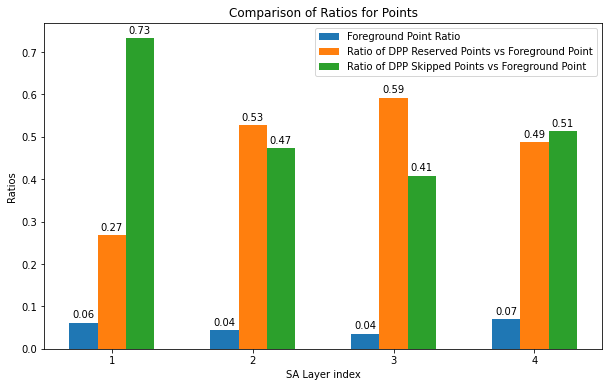

In [7]:
data = np.array(layer_statics)

# Calculate ratios
total_number_of_points_in_box = data[:, 0]
dpp_enable_number_of_points_in_box = data[:, 1]
dpp_disable_number_of_points_in_box = data[:, 2]
total_number_points = data[:, 3]

ratio_total = total_number_of_points_in_box / total_number_points
ratio_dpp_enable = dpp_enable_number_of_points_in_box / total_number_of_points_in_box
ratio_dpp_disable = dpp_disable_number_of_points_in_box / total_number_of_points_in_box

# Create the plot
x = np.arange(data.shape[0])  # label locations
width = 0.2  # bar width

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, ratio_total, width, label='Foreground Point Ratio')
rects2 = ax.bar(x, ratio_dpp_enable, width, label='Ratio of DPP Reserved Points vs Foreground Point')
rects3 = ax.bar(x + width, ratio_dpp_disable, width, label='Ratio of DPP Skipped Points vs Foreground Point')

# Customize the plot
ax.set_xlabel('SA Layer index')
ax.set_ylabel('Ratios')
ax.set_title('Comparison of Ratios for Points')
ax.set_xticks(x)
ax.set_xticklabels(['1', '2', '3', '4'])
ax.legend()

# Function to auto-label bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Show the plot
plt.show()